In [10]:
from learning_lib.nn.monitoring.loss import LossMonitor
from learning_lib.nn.ffnn import FFNN
from learning_lib.nn.cnn import CNN

import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

import tensorflow as tf

import plotly.offline as plotly
import plotly.graph_objs as go
from PIL import Image

In [2]:
%matplotlib inline
plotly.init_notebook_mode(connected=True)

# Problem Statement

Here we compare convolutional neural networks against the feed-forwards variety on MNIST with the aim of improving test accuracy and reduce the number of trainable parameters. We then inspect the filters / convoluted images to see if the "learned features" are human interprable in any way.

Furthermore we show that it is a easier task to learn pattersn from the learned convolutional feature representation of images than it is to classify the raw images itself.

# Data

In [41]:
with gzip.open('MNIST_data/test_input.gz', 'rb') as f:
    test_in = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28) / 255.0
with gzip.open('MNIST_data/train_input.gz', 'rb') as f:
    train_in = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28) / 255.0
with gzip.open('MNIST_data/test_targets.gz', 'rb') as f:
    test_labels_raw = np.frombuffer(f.read(), np.uint8, offset=8)
with gzip.open('MNIST_data/train_targets.gz', 'rb') as f:
    train_labels_raw = np.frombuffer(f.read(), np.uint8, offset=8)
    
test_labels = np.zeros((test_labels_raw.shape[0], 10))
test_labels[np.arange(test_labels_raw.shape[0]), test_labels_raw] = 1
train_labels = np.zeros((train_labels_raw.shape[0], 10))
train_labels[np.arange(train_labels_raw.shape[0]), train_labels_raw] = 1

test_in = test_in.astype('float32')
train_in = train_in.astype('float32')
test_lables = test_labels.astype('float32')
train_lables = train_labels.astype('float32')

In [21]:
# Run this if you want to normalize to zero mean
test_in = test_in - train_in.mean()
train_in = train_in - train_in.mean()

# Feed Forwards Baseline

Here we see that four hidden layers with 128 nodes each achieves 97.88% testing accuracy. Our goal is therefore to beat this number using at most this many parameters.

Tally of number of parameters:
- layer 1: 784 * 128 + 128 = 100480
- layer 2: 128 * 128 + 128 = 16512
- layer 3: 128 * 128 + 128 = 16512
- layer 4: 128 * 128 + 128 = 16512
- layer 5: 128 * 10 + 10 = 1290
- total: 100480 + 16512 + 16512 + 16512 + 1290 = 151306

In [5]:
d = tf.data.Dataset.from_tensor_slices((train_in, train_labels))
d = d.repeat(50)
d = d.batch(300)
iterator = d.make_initializable_iterator()
pipe_out = iterator.get_next()

In [6]:
lc = [
    784,
    {
        'n_nodes': 128, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 128, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 128, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 128, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 10, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    }
]

In [7]:
def cross_entropy_with_softmax(model_output, true_output):
    return tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(labels=true_output, logits=model_output))

In [7]:
monitors = [LossMonitor(200)]

In [8]:
ffnn = FFNN(
    lc, monitors=monitors, optimizer=tf.train.AdamOptimizer(), input_vector=pipe_out[0], train_targets_vector=pipe_out[1]
)
ffnn.init_session()

In [9]:
%%time
for epoch in range(1):
    ffnn.session.run(iterator.initializer)
    ffnn.train_online()

CPU times: user 1min 13s, sys: 4.08 s, total: 1min 17s
Wall time: 1min 2s


In [ ]:
plotly.iplot(ffnn.monitors[0].plot())

In [11]:
train_pred = ffnn.predict(train_in)
np.sum(train_pred.argmax(axis=1) == train_labels.argmax(axis=1)) / train_in.shape[0]

0.9992363636363636

In [14]:
train_pred = ffnn.predict(test_in)
np.sum(train_pred.argmax(axis=1) == test_labels.argmax(axis=1)) / test_in.shape[0]

0.9788

# Convolutional Classifier

We achieve significantly better performance (between 98.35% and 98.55%) with only 8648 trainable parameters.

Tally of number of parameters:
- layer 1: 5 \* 5 * 8 = 200
- layer 2: 5 \* 5 \* 8 * 8 = 1600
- layer 3: 5 \* 5 \* 8 * 8 = 1600
- layer 4: 72 * 64 = 4608
- layer 5: 64 * 10 = 640
- total: 200 + 1600 + 1600 + 4608 + 640 = 8648

In [5]:
d = tf.data.Dataset.from_tensor_slices((train_in.reshape((110000, 28, 28, 1)), train_labels))
d = d.repeat(50)
d = d.batch(300)
iterator = d.make_initializable_iterator()
pipe_out = iterator.get_next()

In [6]:
lc = [
    {
        'layer_type': 'conv',
        'filter_size': [5, 5, 1, 8],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.001,
        'stride_size': [1, 1, 1, 1],
        'activation': tf.tanh
    },
    {
        'layer_type': 'conv',
        'filter_size': [5, 5, 8, 8],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.001,
        'stride_size': [1, 3, 3, 1],
        'activation': tf.tanh
    },
    {
        'layer_type': 'conv',
        'filter_size': [5, 5, 8, 8],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.001,
        'stride_size': [1, 1, 1, 1],
        'activation': tf.tanh
    },
    {
        'layer_type': 'reshape',
        'new_shape': [72]
    },
    {
        'layer_type': 'connected',
        'input_dim': 72,
        'output_dim': 64,
        'activation': tf.tanh,
        'init_weight_mean': 0.0,
        'init_weight_stddev': 0.001,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.001
    },
    {
        'layer_type': 'connected',
        'input_dim': 64,
        'output_dim': 10,
        'activation': tf.tanh,
        'init_weight_mean': 0.0,
        'init_weight_stddev': 0.001,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.001
    }
]

In [7]:
monitors = [LossMonitor(200)]

In [8]:
cnn = CNN(
    lc, monitors=monitors, optimizer=tf.train.AdamOptimizer(), input_vector=pipe_out[0], train_targets_vector=pipe_out[1]
)
cnn.init_session()

In [9]:
%%time
for epoch in range(5):
    cnn.session.run(iterator.initializer)
    cnn.train_online()

CPU times: user 6min 57s, sys: 28.6 s, total: 7min 26s
Wall time: 6min 13s


In [11]:
plotly.iplot(cnn.monitors[0].plot())

In [12]:
train_pred = cnn.predict(train_in.reshape((110000, 28, 28, 1)))
np.sum(train_pred.argmax(axis=1) == train_labels.argmax(axis=1)) / train_in.shape[0]

0.99767272727272727

In [13]:
train_pred = cnn.predict(test_in.reshape((20000, 28, 28, 1)))
np.sum(train_pred.argmax(axis=1) == test_labels.argmax(axis=1)) / test_in.shape[0]

0.97940000000000005

# Exploring CNN Filters

In [36]:
filters_1 = cnn.session.run(cnn.lc[0]['filter'])

def feed_forwards(self, input_vector, n):    
    for i in range(n):
        lc = self.lc[i]

        if lc['layer_type'] == 'conv':
            input_vector = tf.nn.conv2d(
                input=input_vector,
                filter=lc['filter'],
                strides=lc['stride_size'],
                padding='VALID'
            )
            input_vector = lc['activation'](input_vector)

        elif lc['layer_type'] == 'conv_transpose':
            input_vector = tf.nn.conv2d_transpose(
                value=input_vector,
                filter=lc['filter'],
                output_shape=lc['output_size'],
                strides=lc['stride_size']
            )
            input_vector = lc['activation'](input_vector)

        elif lc['layer_type'] == 'connected':
            a = lc['activation']
            w = lc['weights']
            b = lc['biases']
            input_vector = a(tf.matmul(input_vector, w) + b)

        elif lc['layer_type'] == 'pool':
            if lc['pool_type'] == 'average':
                input_vector = tf.nn.avg_pool(
                    value=input_vector,
                    ksize=lc['pool_size'],
                    strides=lc['stride_size'],
                    padding='SAME'
                )
            elif lc['pool_type'] == 'max':
                input_vector = tf.nn.max_pool(
                    value=input_vector,
                    ksize=lc['pool_size'],
                    strides=lc['stride_size'],
                    padding='SAME'
                )

        elif lc['layer_type'] == 'reshape':
            input_vector = tf.reshape(input_vector, [-1] + lc['new_shape'])
            
    return input_vector

## Image

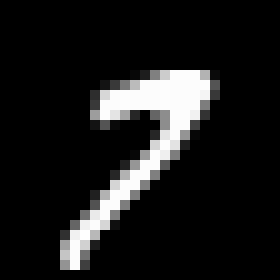

In [37]:
n = 1
image = train_in.reshape((110000, 28, 28, 1))[n:n+1, :, :, :]

f1 = np.repeat(image[0,:,:,0], 10, 0)
f1 = np.repeat(f1, 10, 1)
Image.fromarray((255 * (f1 - f1.min()) / (f1.max() - f1.min())).astype('uint8'), mode='L')

## Layer 1

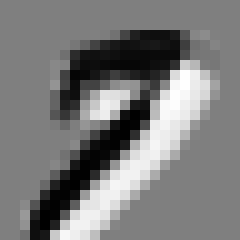

In [38]:
f = cnn.session.run(feed_forwards(cnn, cnn.input, 1), {cnn.input: image})[0, :, :, 2]
f1 = np.repeat(f, 10, 0)
f1 = np.repeat(f1, 10, 1)
Image.fromarray((255 * (f1 - f1.min()) / (f1.max() - f1.min())).astype('uint8'), mode='L')

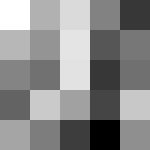

In [39]:
f1 = np.repeat(filters_1[:,:,0,2], 30, 0)
f1 = np.repeat(f1, 30, 1)
f1 = f1
Image.fromarray((255 * (f1 - f1.min()) / (f1.max() - f1.min())).astype('uint8'), mode='L')

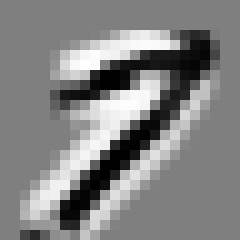

In [40]:
f = cnn.session.run(feed_forwards(cnn, cnn.input, 1), {cnn.input: image})[0, :, :, 0]
f1 = np.repeat(f, 10, 0)
f1 = np.repeat(f1, 10, 1)
Image.fromarray((255 * (f1 - f1.min()) / (f1.max() - f1.min())).astype('uint8'), mode='L')

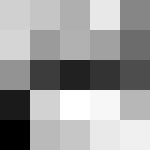

In [41]:
f1 = np.repeat(filters_1[:,:,0,0], 30, 0)
f1 = np.repeat(f1, 30, 1)
f1 = f1
Image.fromarray((255 * (f1 - f1.min()) / (f1.max() - f1.min())).astype('uint8'), mode='L')

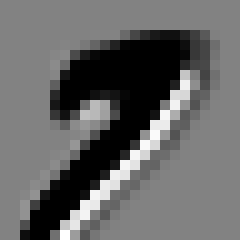

In [42]:
f = cnn.session.run(feed_forwards(cnn, cnn.input, 1), {cnn.input: image})[0, :, :, 6]
f1 = np.repeat(f, 10, 0)
f1 = np.repeat(f1, 10, 1)
Image.fromarray((255 * (f1 - f1.min()) / (f1.max() - f1.min())).astype('uint8'), mode='L')

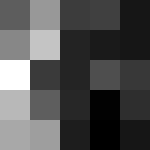

In [43]:
f1 = np.repeat(filters_1[:,:,0,4], 30, 0)
f1 = np.repeat(f1, 30, 1)
f1 = f1
Image.fromarray((255 * (f1 - f1.min()) / (f1.max() - f1.min())).astype('uint8'), mode='L')

# Transfer Learning to KNN

## Raw

In [31]:
knn = KNeighborsClassifier(n_jobs=-1)
knn = knn.fit(train_in[:5000], train_labels[:5000])

In [32]:
np.sum(
    np.argmax(knn.predict(train_in[:5000]), axis=1) != \
    np.argmax(train_labels[:5000], axis=1)
) / train_in[:5000].shape[0]

0.051400000000000001

In [34]:
np.sum(
    np.argmax(knn.predict(test_in[:5000]), axis=1) != \
    np.argmax(test_labels[:5000], axis=1)
) / test_labels[:5000].shape[0]

0.068000000000000005

## 1-Layers

In [60]:
raw_train = train_in[:5000].reshape((5000, 28, 28, 1))
raw_test = test_in[:5000].reshape((5000, 28, 28, 1))

mapped_train = cnn.session.run(feed_forwards(cnn, cnn.input, 1), {cnn.input: raw_train})
mapped_train = mapped_train.reshape((5000, 4608))
mapped_test = cnn.session.run(feed_forwards(cnn, cnn.input, 1), {cnn.input: raw_test})
mapped_test = mapped_test.reshape((5000, 4608))

knn = KNeighborsClassifier(n_jobs=-1)
knn = knn.fit(mapped_train, train_labels[:5000])

In [61]:
np.sum(
    np.argmax(knn.predict(mapped_train), axis=1) != \
    np.argmax(train_labels[:5000], axis=1)
) / mapped_image.shape[0]

0.040599999999999997

In [62]:
np.sum(
    np.argmax(knn.predict(mapped_test), axis=1) != \
    np.argmax(test_labels[:5000], axis=1)
) / mapped_test.shape[0]

0.060600000000000001

## 3-Layers

In [51]:
raw_train = train_in[:5000].reshape((5000, 28, 28, 1))
raw_test = test_in[:5000].reshape((5000, 28, 28, 1))

mapped_train = cnn.session.run(feed_forwards(cnn, cnn.input, 3), {cnn.input: raw_train})
mapped_train = mapped_train.reshape((5000, 72))
mapped_test = cnn.session.run(feed_forwards(cnn, cnn.input, 3), {cnn.input: raw_test})
mapped_test = mapped_test.reshape((5000, 72))

knn = KNeighborsClassifier(n_jobs=-1)
knn = knn.fit(mapped_train, train_labels[:5000])

In [53]:
np.sum(
    np.argmax(knn.predict(mapped_train), axis=1) != \
    np.argmax(train_labels[:5000], axis=1)
) / mapped_image.shape[0]

0.014

In [55]:
np.sum(
    np.argmax(knn.predict(mapped_test), axis=1) != \
    np.argmax(test_labels[:5000], axis=1)
) / mapped_test.shape[0]

0.023800000000000002

# Transfer Learning to SVM

## Raw

In [65]:
svm = LinearSVC()
svm = svm.fit(train_in[:5000], np.argmax(train_labels[:5000], axis=1))

In [71]:
np.sum(
    svm.predict(train_in[:5000]) != \
    np.argmax(train_labels[:5000], axis=1)
) / train_in[:5000].shape[0]

0.0083999999999999995

In [72]:
np.sum(
    svm.predict(test_in[:5000]) != \
    np.argmax(test_labels[:5000], axis=1)
) / test_labels[:5000].shape[0]

0.1152

## 1-Layers

In [82]:
raw_train = train_in[:5000].reshape((5000, 28, 28, 1))
raw_test = test_in[:5000].reshape((5000, 28, 28, 1))

mapped_train = cnn.session.run(feed_forwards(cnn, cnn.input, 1), {cnn.input: raw_train})
mapped_train = mapped_train.reshape((5000, 4608))
mapped_test = cnn.session.run(feed_forwards(cnn, cnn.input, 1), {cnn.input: raw_test})
mapped_test = mapped_test.reshape((5000, 4608))

svm = LinearSVC()
svm = svm.fit(mapped_train, np.argmax(train_labels[:5000], axis=1))

In [84]:
np.sum(
    svm.predict(mapped_train) != \
    np.argmax(train_labels[:5000], axis=1)
) / mapped_image.shape[0]

0.0

In [85]:
np.sum(
    svm.predict(mapped_test) != \
    np.argmax(test_labels[:5000], axis=1)
) / mapped_test.shape[0]

0.032599999999999997

## 3-Layers

In [89]:
raw_train = train_in[:5000].reshape((5000, 28, 28, 1))
raw_test = test_in[:5000].reshape((5000, 28, 28, 1))

mapped_train = cnn.session.run(feed_forwards(cnn, cnn.input, 3), {cnn.input: raw_train})
mapped_train = mapped_train.reshape((5000, 72))
mapped_test = cnn.session.run(feed_forwards(cnn, cnn.input, 3), {cnn.input: raw_test})
mapped_test = mapped_test.reshape((5000, 72))

svm = LinearSVC()
svm = svm.fit(mapped_train, np.argmax(train_labels[:5000], axis=1))

In [90]:
np.sum(
    svm.predict(mapped_train) != \
    np.argmax(train_labels[:5000], axis=1)
) / mapped_image.shape[0]

0.0014

In [91]:
np.sum(
    svm.predict(mapped_test) != \
    np.argmax(test_labels[:5000], axis=1)
) / mapped_test.shape[0]

0.023199999999999998